In [4]:
import sys as sys

print(sys.path)
# If running notebook outside of CellUntangler directory, add it to the path
sys.path.append('/content/CellUntangler/')

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [5]:
import os

import torch

from src.data.umi_data import UMIVaeDataset
from src.celluntangler import utils
from src.celluntangler.models import Trainer
from src.celluntangler.models.nb_vae import NBVAE
import numpy as np

import pandas as pd
import scanpy as sc

# HeLa CellUntangler Tutorial

We will apply CellUntangler to a dataset of HeLa cells to capture the cell cycle in one latent representation and non-cell cycle signals in another representation.

The dataset can be accessed at: [HeLa](https://drive.google.com/file/d/1eOAGupayrU2d_Day2PrV7ce8Jiq0RgBT/view?usp=sharing).

## Read in and process the data.

In [ ]:
hela_dataset_path = "/content/drive/MyDrive/mvae_research/datasets/revelio_paper/hela/hela_select_with_phase.h5ad"
adata = sc.read_h5ad(hela_dataset_path)

Read in the cell cycle marker genes that will be used to capture the cell cycle signal.
The cell cycle marker genes can be accessed at: [CellUntangler Cell Cycle Marker Genes](https://drive.google.com/file/d/1DIh9Jfc0vS3-fETCHm1ClxOQTHQB_-ef/view?usp=sharing).

In [ ]:
cell_cycle_genes_path = "/content/drive/MyDrive/mvae_research/cyc_gene_2023_1219_v1.tsv"
cell_cycle_genes = pd.read_csv(cell_cycle_genes_path, header=None, sep="\t")

Rearrange the genes so that cell cycle marker genes are placed first followed by the rest of the non-cell cycle genes.

In [ ]:
# Genes involved with the cell cycle present in adata
contained_genes = adata.var["gene_symbols"].isin(cell_cycle_genes[0])
print(f"Number of cell cycle genes present in adata: {np.sum(contained_genes)}")
cycle_gene_indices = np.where(contained_genes)[0]
non_cycle_gene_indices = np.where(~contained_genes)[0]
rearranged_indices = np.hstack((cycle_gene_indices, non_cycle_gene_indices))
adata = adata[:, rearranged_indices]
adata.uns["new_gene_ordering"] = rearranged_indices

## Obtain the configuration for the hyperparameters for the CellUntangler model and for training the model.

In [9]:
from src.celluntangler.models.get_config import get_config

In [10]:
config = get_config()

To capture the cell cycle in one representation, we use the hyperbolic space with the rotated wrapped normal distribution (RoWN) with a dimension of 2, which is denoted as r2.

To capture the non-cell cycle signals in the other representation, we use the Euclidean space with a dimension of 10, which is denoted as e10.

Hence the model name is r2, e10.

In [11]:
config.model_name = "r2, e10"

In [12]:
config.seed = 68715

Set initialization to "custom", because we are training for the cell cycle.

In [13]:
config.init = "custom"

## Create the training and test datasets.

In [14]:
x = adata.X.todense().astype(np.double)
batch = (np.zeros((x.shape[0], 1)) * -1).astype(np.int64)
# y holds the batch vector for the dataset
y = batch

In [15]:
# Create the dataset and separate it into training and test sets
in_dim = x.shape[1]
print(f"in_dim = {in_dim}")
batch_size = config.batch_size
dataset = UMIVaeDataset(batch_size=batch_size, in_dim=in_dim)
print(f"dataset.in_dim = {dataset.in_dim}")
# Create the dataset loaders
train_loader = dataset.create_loaders(x, y, seed=config.seed)

in_dim = 4545
dataset.in_dim = 4545
Dataset seed: 68715


## Create the mask to be used to separate $\mathbf{x}$ into different components that are used when training the model.

In [16]:
# A mask that is 1 where the gene is a cell cycling gene and 0 otherwise
mask_cyc = np.zeros(adata.n_vars)
mask_cyc[adata.var["gene_symbols"].isin(cell_cycle_genes[0])] = 1

# A mask that is 0 where the gene is a cell cycling gene and 1 otherwise
mask_all = np.ones(adata.n_vars)
mask_all[adata.var["gene_symbols"].isin(cell_cycle_genes[0])] = 0

mask = torch.tensor([mask_cyc, mask_all])

<ipython-input-16-614bb1bd5b0f>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mask = torch.tensor([mask_cyc, mask_all])


In [17]:
for row in mask:
  print(row)
  print(torch.sum(row).item())

tensor([1., 1., 1.,  ..., 0., 0., 0.], dtype=torch.float64)
174.0
tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)
4371.0


## Train CellUntangler.

In [18]:
torch.set_default_dtype(torch.float64)

Below is to save embeddings generated through the epochs. Set visualization_information = None if it is not desired.

In [19]:
# The path to save the intermediate embeddings to
epoch_embeddings_save_path = "./"
visualize_information={}
# The epochs to save the intermediate embeddings for
visualize_information["epochs"]=[i for i in range(0, 500, 50)]
visualize_information["x"]=x
visualize_information["y"]=y
visualize_information["embeddings_save_path"]=epoch_embeddings_save_path
visualize_information["model_name"]=config.model_name

In [20]:
config

activation: gelu
batch_invariant: true
batch_size: 128
device: cpu
end: 1.0
end_epoch: 1
end_z2_no_grad: 500
epochs: 200
eps: 0.001
fixed_curvature: true
gain: 1.0
h_dim: 32
init: custom
learning_rate: 0.001
max_epochs: 500
model_name: r2, e10
momentum: 0.99
n_batch:
- 1
scalar_parametrization: false
seed: 68715
start: 1.0
start_z2_no_grad: 0
use_adamw: true
use_batch_norm: false
use_z2_no_grad: false
weight_decay: null

In [ ]:
if config.seed:
    print(config.seed)
    torch.manual_seed(config.seed)
    np.random.seed(config.seed)
    np.random.default_rng(config.seed)

model_name = config.model_name
components = utils.parse_components(model_name, config.fixed_curvature)
# =====
model = NBVAE(h_dim=config.h_dim,
              components=components,
              mask=mask,
              dataset=dataset,
              config=config).to(config.device)

trainer = Trainer(model)

optimizer = trainer.build_optimizer(learning_rate=config.learning_rate,
                                        fixed_curvature=config.fixed_curvature,
                                        use_adamw=config.use_adamw,
                                        weight_decay=config.weight_decay)

betas = utils.linear_betas(config.start,
                           config.end,
                           end_epoch=config.end_epoch,
                           epochs=config.epochs)

trainer.train_epochs(optimizer=optimizer,
                       train_data=train_loader,
                       betas=betas,
                       likelihood_n=0,
                       max_epochs=config.max_epochs,
                           visualize_information=visualize_information)

68715
Linear(in_features=32, out_features=2, bias=True)
initializing Xavier uniform weights in Linear
Linear(in_features=32, out_features=2, bias=True)
initializing Xavier uniform weights in Linear
RotatedHyperbolicComponent(R^3)
	TrainEpoch 0:	{'bce': -4114.15356814241, 'kl': 4.2377339206770355, 'elbo': -4118.391302063087, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 1:	{'bce': -3406.196271370782, 'kl': 53.520041668298255, 'elbo': -3459.7163130390804, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 2:	{'bce': -3090.3074418190795, 'kl': 25.12237605787321, 'elbo': -3115.4298178769527, 'll': 0.0, 'mi': 0.0, 'cov_norm': 0.0, 'beta': 1.0, 'comp_000_r2/curvature': -2.0000000000000004, 'comp_001_e10/curvature': 0.0}
	TrainEpoch 3:	{'bce': -2979.07663690386, 'kl': 15.01120219775873, 'elbo': -2994.0878391016

Save the trained embeddings.

In [ ]:
embeddings_save_path = "./"
a = trainer.model(torch.log1p(torch.tensor(x)), torch.tensor(y))
np.savetxt(os.path.join(embeddings_save_path, f'{model_name}_all_encode_v63_z_params.txt'), a[4].detach().numpy())

Save the gene expression matrices enhanced and filtered for the cell cycle.

In [ ]:
gene_expression_matrix_path = "./"

In [ ]:
import torch.nn as nn
# Encode the batch vector which must also be passed to the decoder
batch = nn.functional.one_hot(torch.tensor(y[:,0]), 1)

library_size = torch.sum(torch.tensor(x), dim=1)

In [ ]:
# To enhance the cell cycle, mask the non-cell cycle latent representation and pass it to the decoder
# The latent representations have a dimension of 13 because the hyperbolic latent representation
# has a dimension of 3 and the Euclidean latent representation has a dimension of 10
z1_mask = torch.zeros(13)
z1_mask[0:3] = 1

z_params = a[4].detach()
x_z1_params_mu = trainer.model.decode(z_params*z1_mask, batch)[0]
x_z1_params_mu = x_z1_params_mu * library_size[:, None]
np.savetxt(os.path.join(gene_expression_matrix_path,"x_z1_params_mu.txt"), x_z1_params_mu.detach().numpy())

In [ ]:
# To enhance the cell cycle, mask the non-cell cycle latent representation and pass it to the decoder
# The latent representations have a dimension of 13 because the hyperbolic latent representation
# has a dimension of 3 and the Euclidean latent representation has a dimension of 10
z2_mask = torch.zeros(13)
z2_mask[3:] = 1

z_params = a[4].detach()
x_z2_params_mu = trainer.model.decode(z_params*z2_mask, batch)[0]
x_z2_params_mu = x_z2_params_mu * library_size[:, None]
np.savetxt(os.path.join(gene_expression_matrix_path,"x_z2_params_mu.txt"), x_z2_params_mu.detach().numpy())

## Evaluate and analyze the embeddings.

### Visualize the embeddings.

In [ ]:
import matplotlib.pyplot as plt

from src.visualization.helpers import split_embeddings
from src.visualization.visualization_functions import visualize_poincare_from_lorentz, compute_umap

In [ ]:
embeddings_save_path = "./"
model_name = "r2, e10"
# Load in the embeddings
embeddings = np.loadtxt(os.path.join(embeddings_save_path, f'{model_name}_all_encode_v63_z_params.txt'))

In [ ]:
# Returns a dictionary where the keys are of the format componenti_subspace
# E.g., r2, e10 would result in keys of component1_r2 and component2_e10
# The values are the corresponding embeddings
component_embeddings = split_embeddings(model_name, embeddings)
for c in component_embeddings:
    adata.obsm[c] = component_embeddings[c]

r2 3
e10 10


Visualize $\mathbf{z}^1 \in \mathbb{H}^2$ when projected to Poincare coordinates and colored by cell cycle phase. The cells separate by cell cycle phase and proceed in the expected order (G1.S $\rightarrow$ S $\rightarrow$ G2 $\rightarrow$ G2.M $\rightarrow$ M.G1).

-2
0.7
Index(['G1.S', 'G2', 'G2.M', 'M.G1', 'S'], dtype='object')


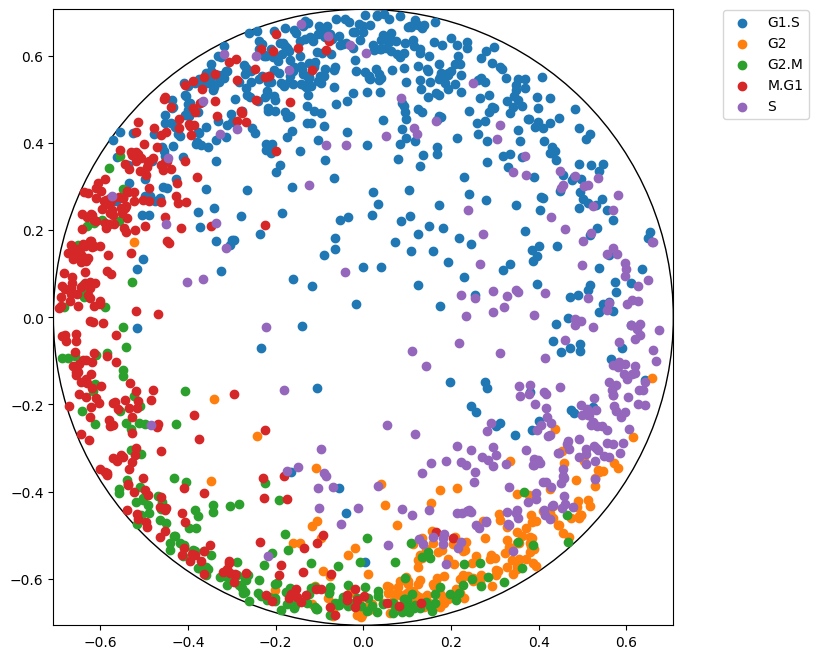

In [ ]:
embeddings_key = "component1_r2"
desired_obs = 'ccPhase'
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.23,1.01)
fig = visualize_poincare_from_lorentz(adata.obsm[embeddings_key],
                       desired_obs_all,
                       curvature=-2,
                      embedding_type='discrete',
                       cmap=plt.cm.viridis,
                       cat_colors=None,
                      grid_lines=True,
                      c_bar_label="Transcriptional Phase",
                      bbox_to_anchor=legend_coordinates)

Visualize $\mathbf{z}^1 \in \mathbb{H}^2$ when projected to Poincare coordinates and colored by wild type (WT) and knockout (Ago2KO). The cells are mixed together.

-2
0.7
Index(['Ago2KO', 'WT'], dtype='object')


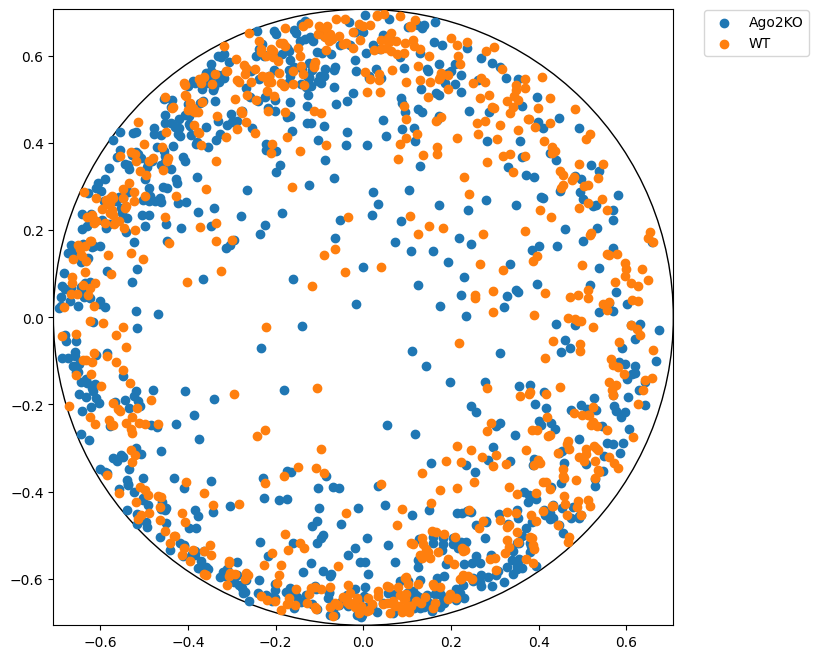

In [ ]:
embeddings_key = "component1_r2"
desired_obs = 'batch'
desired_obs_all = adata.obs[desired_obs]
legend_coordinates = (1.23,1.01)
fig = visualize_poincare_from_lorentz(adata.obsm[embeddings_key],
                       desired_obs_all,
                       curvature=-2,
                      embedding_type='discrete',
                       cmap=plt.cm.viridis,
                       cat_colors=None,
                      grid_lines=True,
                      c_bar_label="Transcriptional Phase",
                      bbox_to_anchor=legend_coordinates)

Visualize $\mathbf{z}^2 \in \mathbb{E}^{10}$ when projected to 2D using UMAP and colored by cell cycle phase and wild type (WT) and knockout (Ago2KO). The cells are mixed by cell cycle and separated by wild type and knockout.

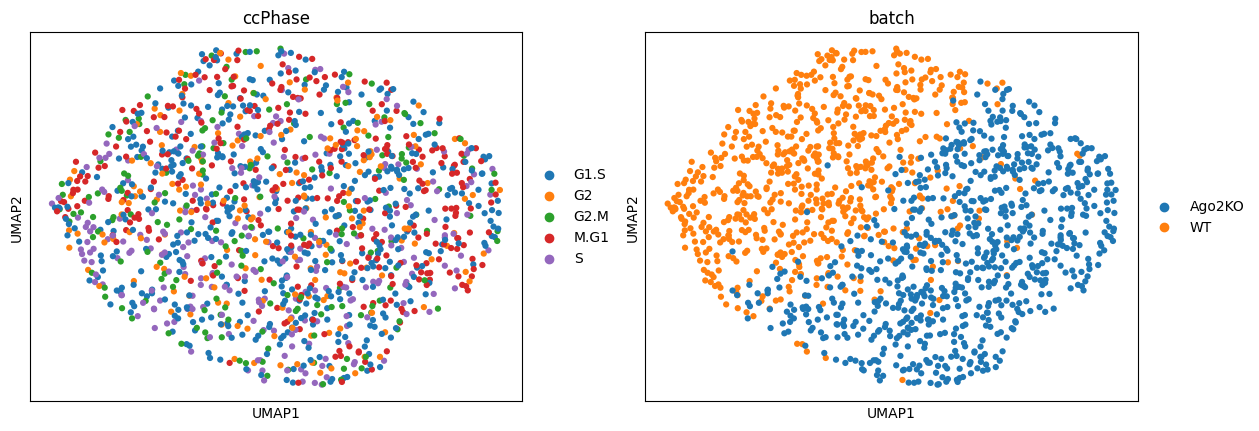

In [ ]:
compute_umap(adata,
             l_neighbors=50,
             color=['ccPhase','batch'],
             n_pcs=None,
             embeddings_key="component2_e10",
             use_original_umap=False,
             palette=None,
             additional_save_information=[],
             title=None,
             save_figure=False)

### Obtain the cell cycle pseudotime.

In [ ]:
from src.visualization.helpers import get_mvae_pseudotime

In [ ]:
embeddings_key = 'component1_r2'
# The curvature of the space
curvature = -2
# The point to measure pseudotime from
pseudotime_origin = (0.0, 0.0)
# If recentering the cells, the new origin
new_origin = (0.0, 0.0)
# The angle to rotate the cells by around the origin (0.0, 0.0)
rotation_angle = 0
# Whether to flip the orientation of the cells so cells assigned a pseudotime of 0 will be assigned a pseudotime of 2pi and vice versa
flip = True

adata.obs['mvae_pseudotime'] = get_mvae_pseudotime(adata.obsm[embeddings_key],
                                                 curvature,
                                                 pseudotime_origin,
                                                 rotation_angle,
                                                 flip,
                                                 new_origin)[1]
sorting_order = np.argsort(adata.obs["mvae_pseudotime"].values)
adata.uns['mvae_pseudotime_order'] = sorting_order

[ 0.11326947  0.23759736  0.25361587 ...  0.47099128 -0.05143907
  0.36633181]
[-0.52017949 -0.59421356  0.04380375 ... -0.06965148 -0.47503861
 -0.40096926]


### Visualize the gene expression after ordering cells by pseudotime.

If the data is the raw counts, log-normalize.

In [ ]:
import copy as copy

from src.visualization.helpers import make_dir
from src.visualization.visualization_functions import plot_gene_change

In [ ]:
original_adata = copy.deepcopy(adata)

In [ ]:
# sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
# orig_adata  = adata.copy()
# sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)

In [ ]:
adata.var.index = adata.var["gene_symbols"]

In [ ]:
adata.X = adata.X.todense()

/usr/local/lib/python3.10/dist-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


Some cell cycle genes to visualize.

In [ ]:
G1_S_genes = ["CCNE2","ORC1","CCNE1","MCM6"]
S_genes = ["CCNE2","RRM2"]
G2_genes = ["CDK1","CCNF","NUSAP1","CCNA2"]
G2_M_genes = ["CCNB1","CDC20","NUSAP1","AURKA","CCNA2","CCNB2"]
M_genes = ["CDC20"]

subset_phase_genes = {"G1_S": G1_S_genes,
                "S": S_genes,
               "G2": G2_genes,
               "G2_M": G2_M_genes,
               "M": M_genes}

Associate each of the cells with the corresponding cell cycle phase color. *E.g.*, S cells are purple.

In [ ]:
ordered_ccPhase = ["G1.S","S","G2","G2.M","M.G1"]
adata.obs['ccPhase_ordered'] = pd.Categorical(values=adata.obs['ccPhase'], categories=ordered_ccPhase,ordered=True)

In [ ]:
ccPhase_palette={"G1.S":"tab:blue",
                 "S":"tab:purple",
                 "G2":"tab:orange",
                 "G2.M":"tab:green",
                 "M.G1":"tab:red"}

In [ ]:
cell_cycle_obs = "ccPhase_ordered"
colors = [ccPhase_palette[phase] for phase in adata.obs[cell_cycle_obs][adata.uns["mvae_pseudotime_order"]]]
colors = np.array(colors)
labels = adata.obs[cell_cycle_obs][adata.uns["mvae_pseudotime_order"]]

<ipython-input-47-8c4d953f9dcf>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  colors = [ccPhase_palette[phase] for phase in adata.obs[cell_cycle_obs][adata.uns["mvae_pseudotime_order"]]]
<ipython-input-47-8c4d953f9dcf>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = adata.obs[cell_cycle_obs][adata.uns["mvae_pseudotime_order"]]


Directory to save the visualized gene expression to.

In [ ]:
gene_save_dir_path="./"
gene_save_path = os.path.join(gene_save_dir_path,"cycle_genes")
if not os.path.exists(gene_save_path):
  os.mkdir(gene_save_path)

Visualize the genes.

In [ ]:
phase_genes = subset_phase_genes

['CCNE2', 'ORC1', 'CCNE1', 'MCM6']
[1.3275722 1.3516222 1.525712  ... 2.0736878 0.        0.       ]


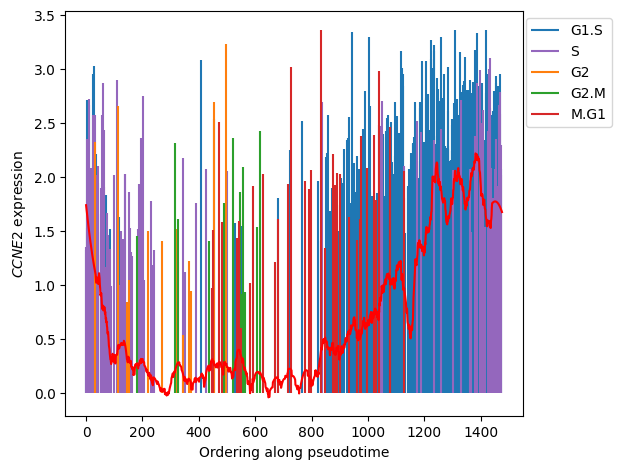

[1.7262945 2.5221024 0.        ... 0.        0.        0.       ]


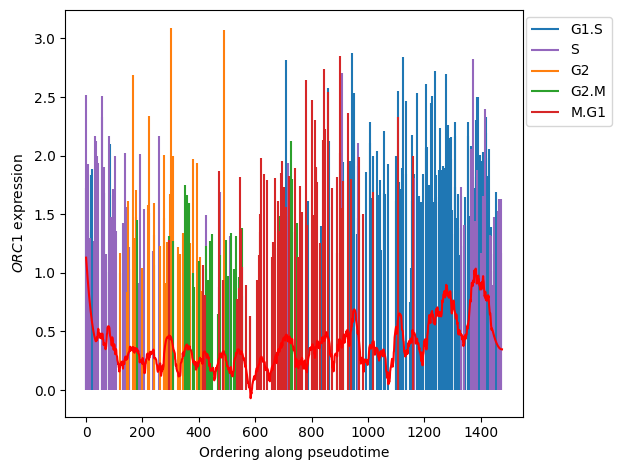

[0.        0.        0.        ... 2.0736878 0.        0.       ]


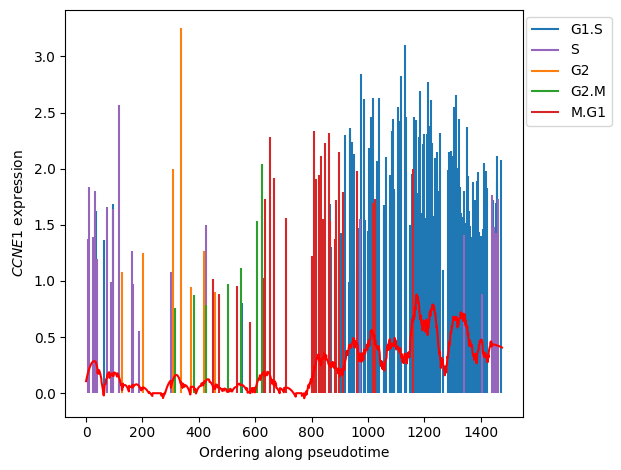

[1.7262945 2.2608318 2.9440222 ... 0.        0.        0.       ]


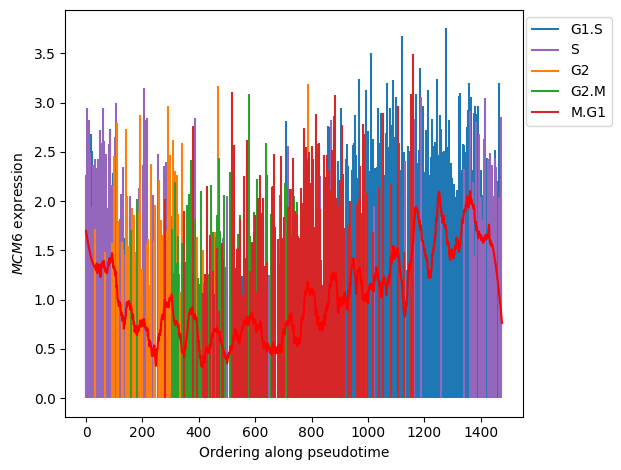

['CCNE2', 'RRM2']
[1.3275722 1.3516222 1.525712  ... 2.0736878 0.        0.       ]


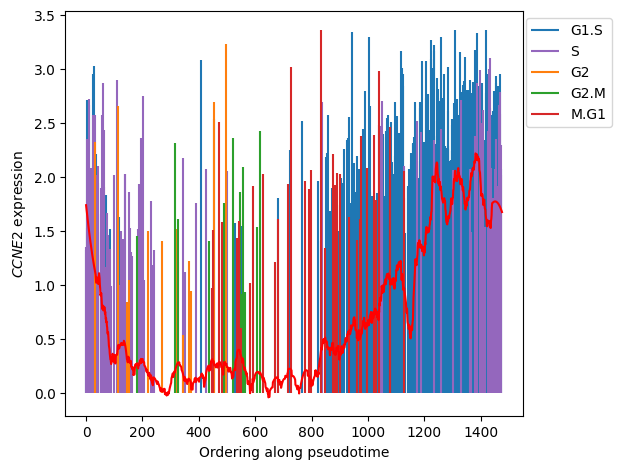

[2.9693456 2.9004393 2.1037478 ... 3.360945  2.5712495 2.4611359]


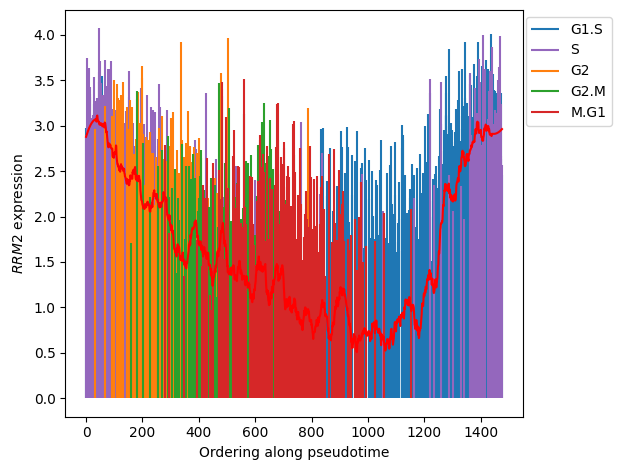

['CDK1', 'CCNF', 'NUSAP1', 'CCNA2']
[3.3575501 2.7290573 2.1037478 ... 3.084764  3.2254272 3.5011737]


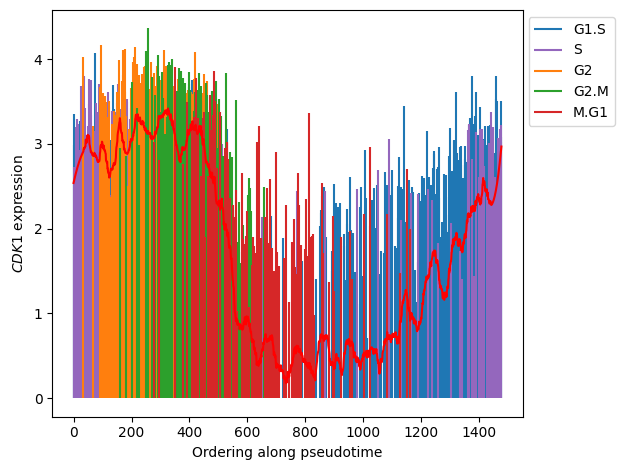

[0.6543847 0.        1.525712  ... 0.        1.6149002 0.       ]


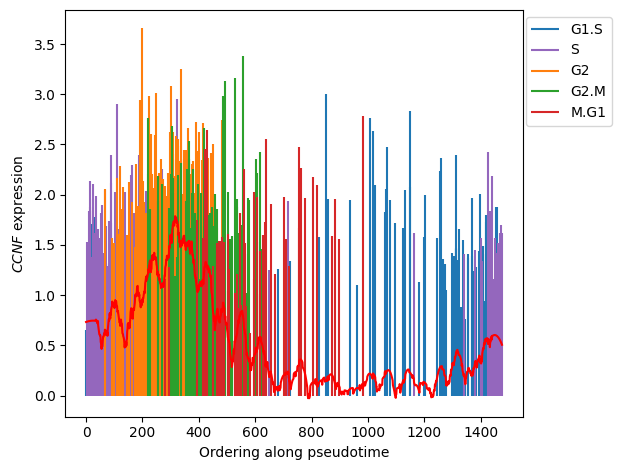

[3.1821685 3.6435668 3.2653363 ... 3.5771239 2.5712495 3.5011737]


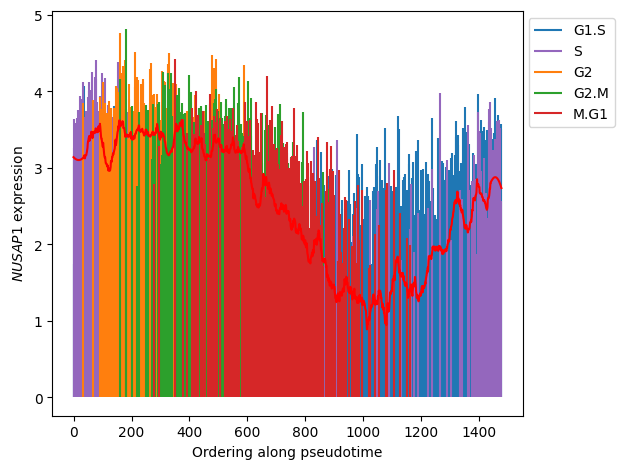

[2.231693  1.9061853 0.        ... 2.0736878 1.6149002 0.       ]


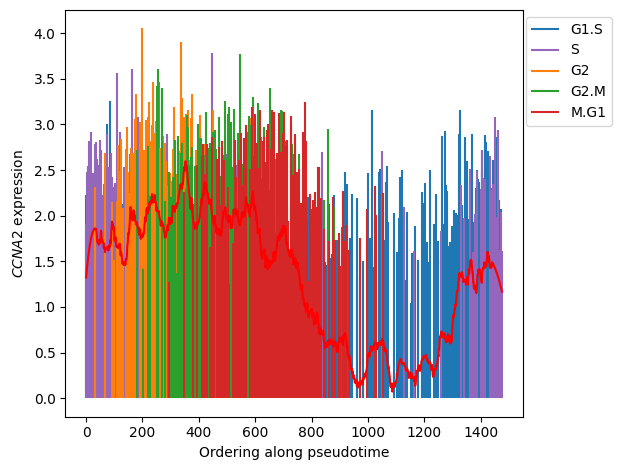

['CCNB1', 'CDC20', 'NUSAP1', 'AURKA', 'CCNA2', 'CCNB2']
[1.8785104 1.3516222 1.525712  ... 0.        1.6149002 2.4611359]


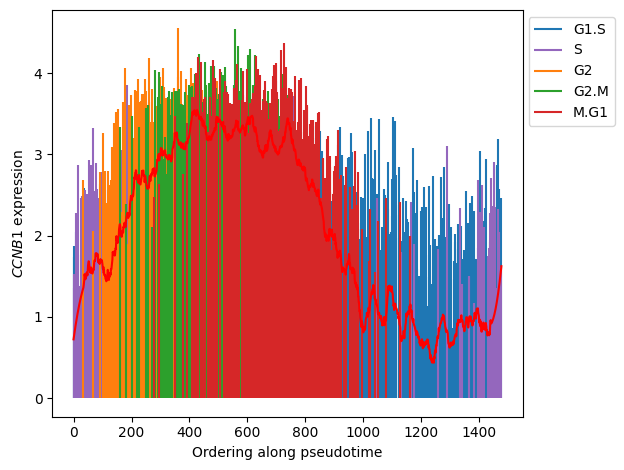

[1.8785104 0.        0.        ... 0.        0.        0.       ]


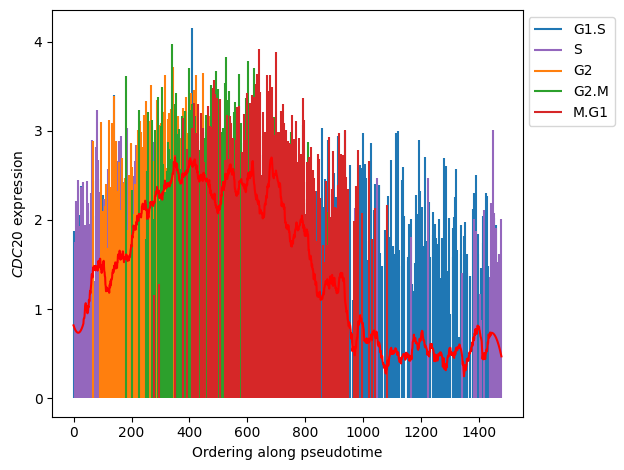

[3.1821685 3.6435668 3.2653363 ... 3.5771239 2.5712495 3.5011737]


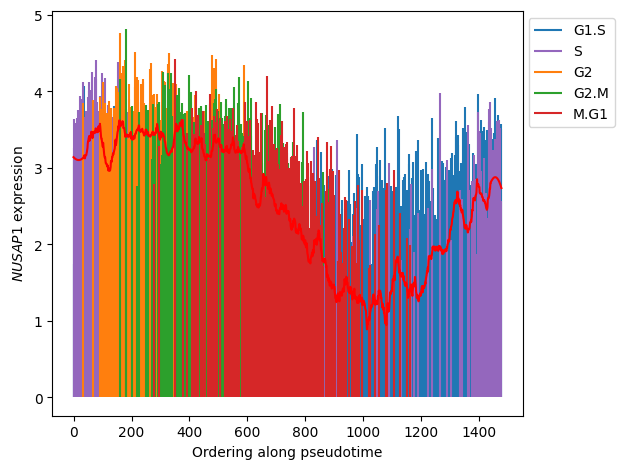

[1.5466756 0.        2.1037478 ... 2.0736878 0.        0.       ]


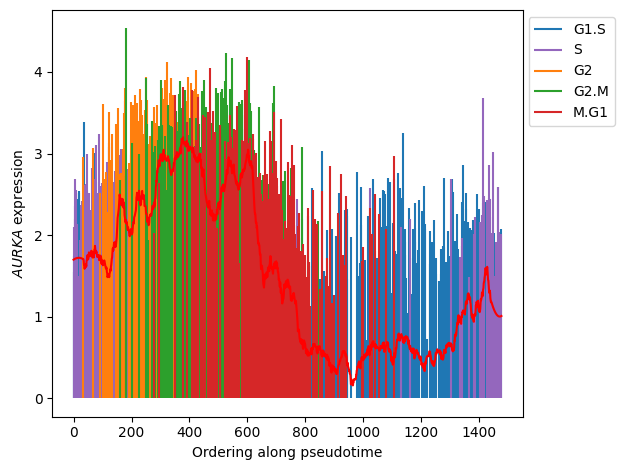

[2.231693  1.9061853 0.        ... 2.0736878 1.6149002 0.       ]


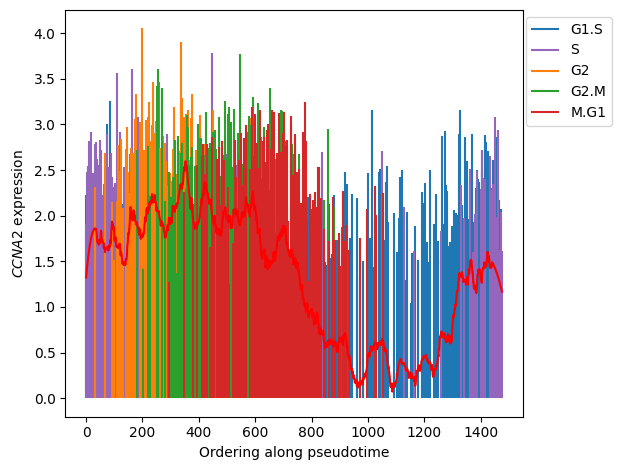

[1.0465877 1.9061853 0.        ... 0.        2.203292  0.       ]


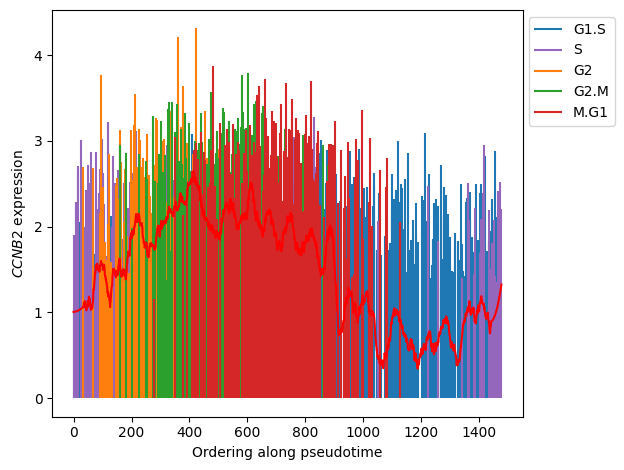

['CDC20']
[1.8785104 0.        0.        ... 0.        0.        0.       ]


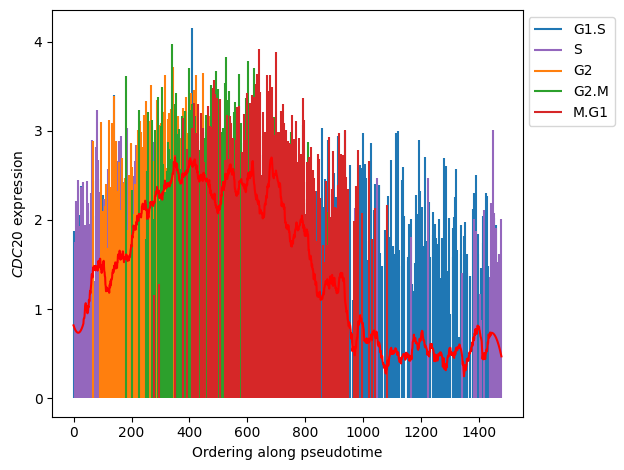

In [ ]:
desired_phases = subset_phase_genes.keys()
for desired_phase in desired_phases:
    phase_gene_list = phase_genes[desired_phase]
    print(phase_gene_list)
    make_dir(gene_save_path, desired_phase)
    phase_dir_path = os.path.join(gene_save_path, desired_phase)
    for gene in phase_gene_list:

        if gene in adata.var.index:

            phase_dir_path = os.path.join(gene_save_path,desired_phase)

            plot_gene_change(adata[adata.uns['mvae_pseudotime_order']],desired_phase,gene,colors,labels,phase_dir_path,ccPhase_palette=None)

### Obtain the enhanced and filtered gene expression matrices

If the genes are not already rearranged, make sure that they are since the genes of the adata should be in the same order as the expression matrix passed to CellUntangler.

Read in the matrices.

In [ ]:
gene_expression_matrix_path = "./"
x_z1_params_mu = np.loadtxt(os.path.join(gene_expression_matrix_path,"x_z1_params_mu.txt"))
x_z2_params_mu = np.loadtxt(os.path.join(gene_expression_matrix_path,"x_z2_params_mu.txt"))

In [ ]:
adata.layers["enhanced"] = x_z1_params_mu.copy()
adata.layers["filtered"] = x_z2_params_mu.copy()

Perform PCA on the gene matrix enhanced for the cell cycle and visualize the gene expression of the gene matrix enhanced for the cell cycle.

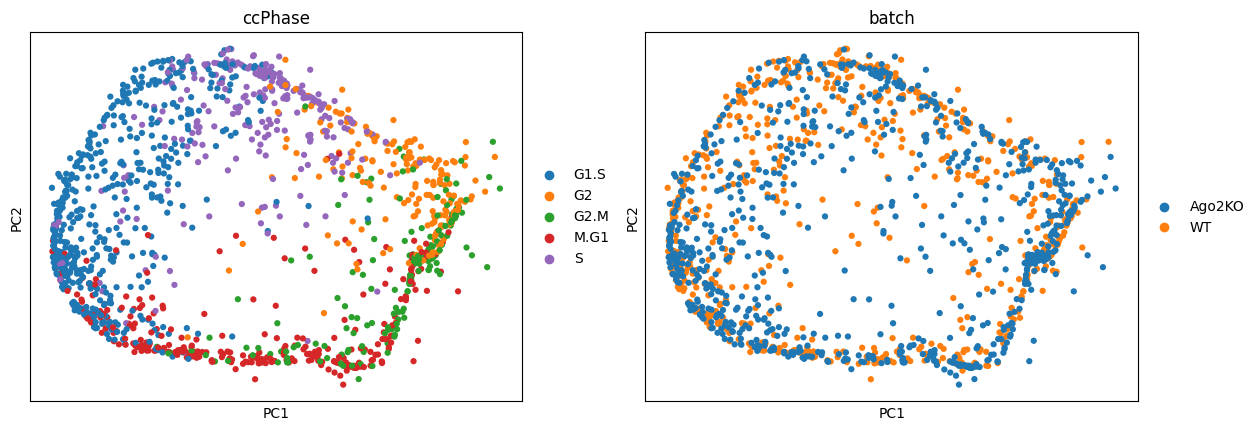

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4, layer="enhanced")
sc.pp.log1p(adata, layer="enhanced")
sc.pp.pca(adata, n_comps=50, layer="enhanced")
sc.pl.pca(adata, color=["ccPhase", "batch"])

['CCNE2', 'ORC1', 'CCNE1', 'MCM6']
[1.89303146 1.94984325 1.99400218 ... 2.21123278 1.61630103 2.16773049]


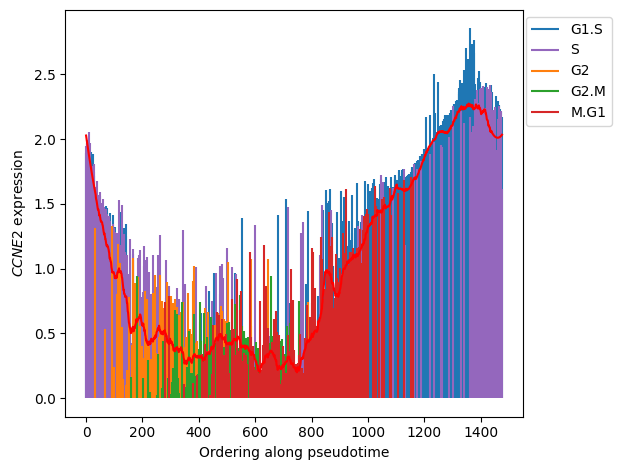

[0.94467049 0.95185334 0.95952686 ... 1.10287844 1.00669406 1.02747027]


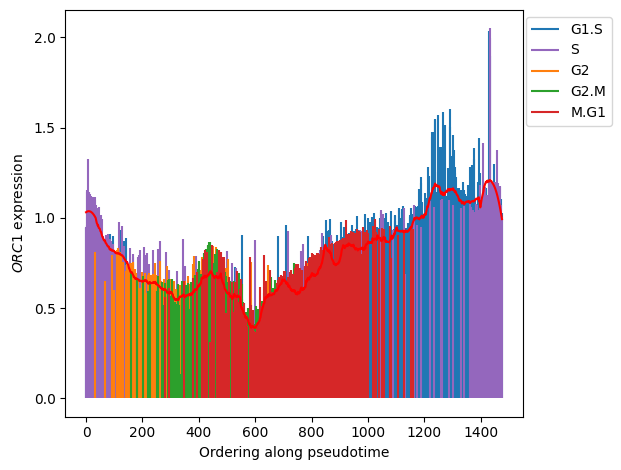

[0.25545528 0.24529051 0.23469084 ... 0.24240628 0.36773091 0.23837842]


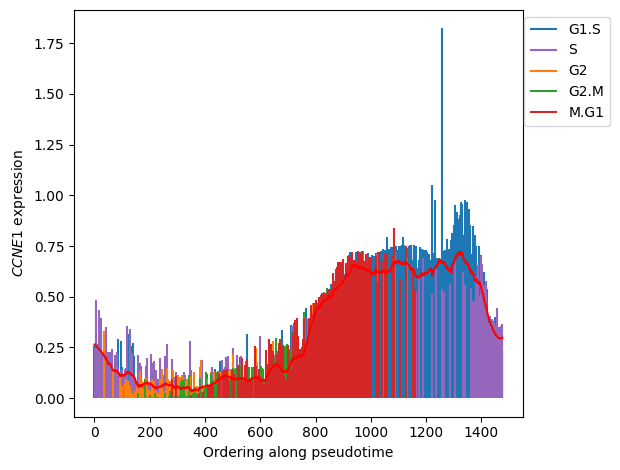

[2.00560037 2.02632964 2.04003903 ... 1.97573574 1.90112781 2.0477446 ]


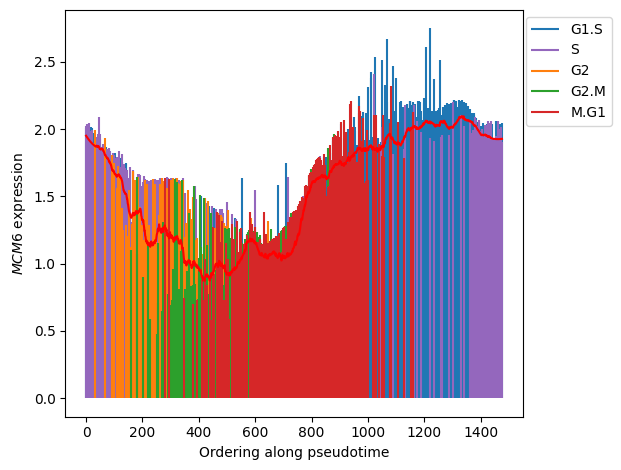

['CCNE2', 'RRM2']
[1.89303146 1.94984325 1.99400218 ... 2.21123278 1.61630103 2.16773049]


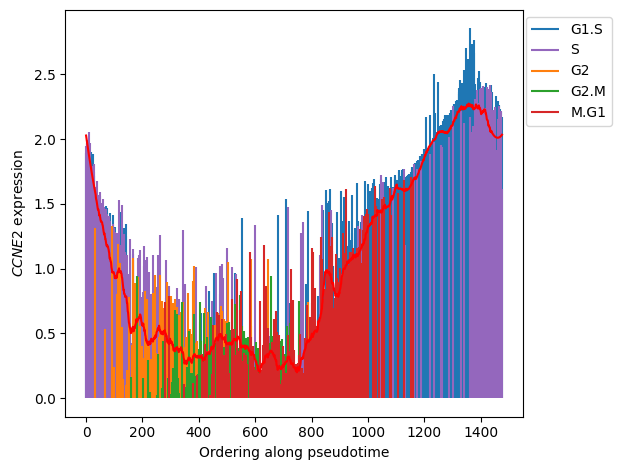

[2.9543427  2.96629407 2.97888178 ... 3.09885985 2.88403254 3.03230987]


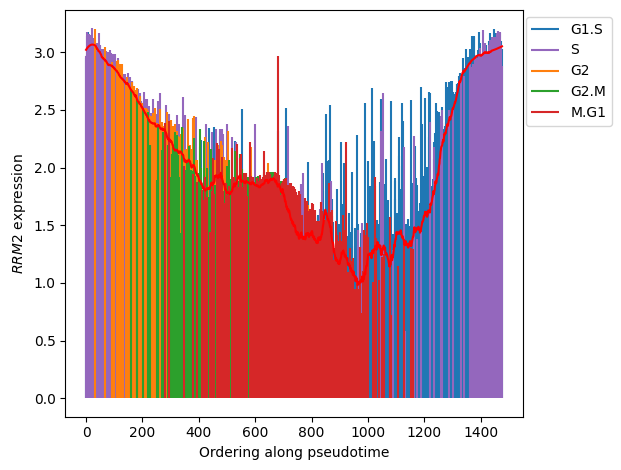

['CDK1', 'CCNF', 'NUSAP1', 'CCNA2']
[2.75292862 2.75039834 2.75218349 ... 2.75750598 2.56069146 2.75198126]


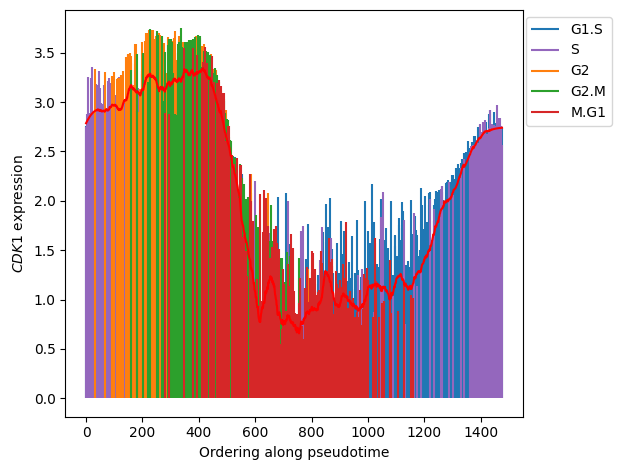

[0.76499223 0.75173386 0.74806017 ... 0.77342012 0.8306476  0.74348075]


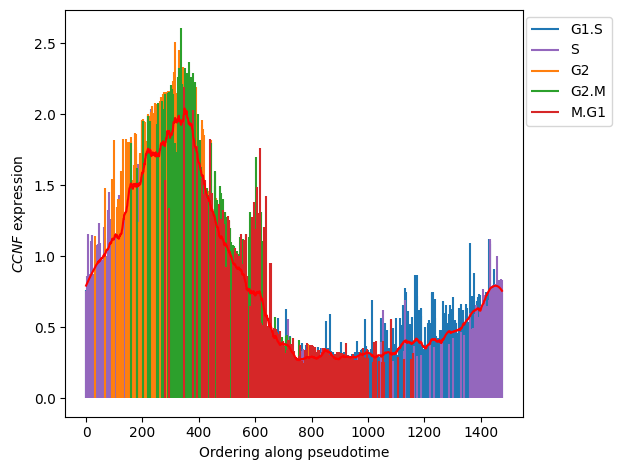

[3.1274449  3.16325738 3.1996115  ... 3.30330559 2.75359466 3.26269282]


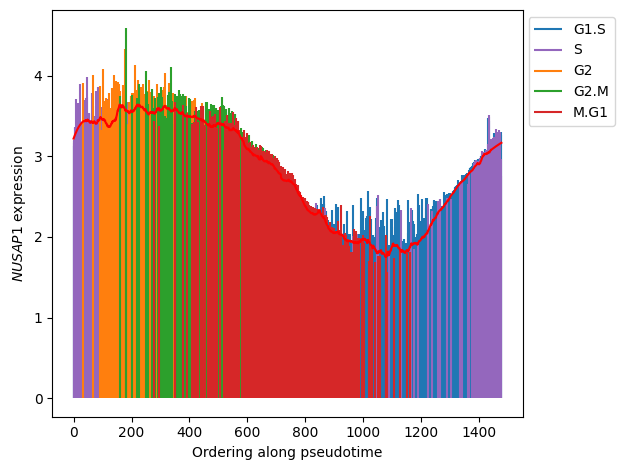

[1.88405808 1.87323494 1.86255205 ... 1.87047468 1.92598676 1.84875215]


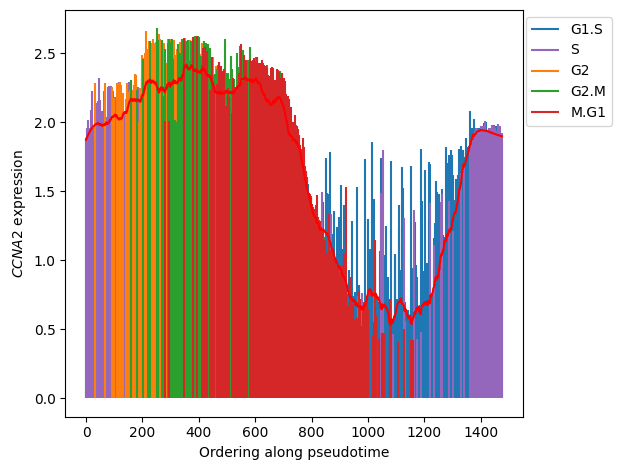

['CCNB1', 'CDC20', 'NUSAP1', 'AURKA', 'CCNA2', 'CCNB2']
[1.5997576  1.6094845  1.62410512 ... 1.76246432 1.6123626  1.69469406]


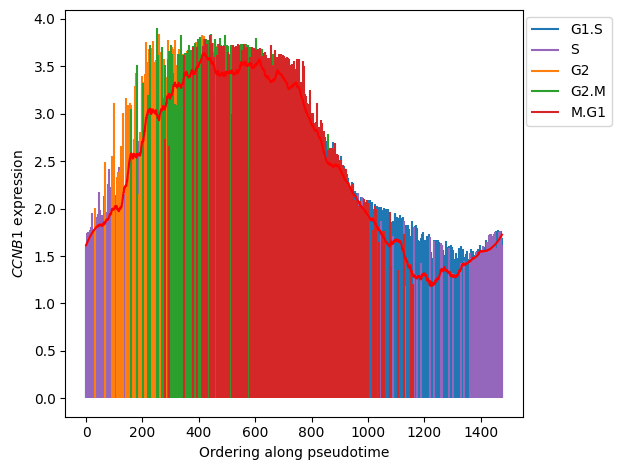

[1.21804723 1.18907888 1.17308385 ... 1.16978806 1.48815894 1.13838535]


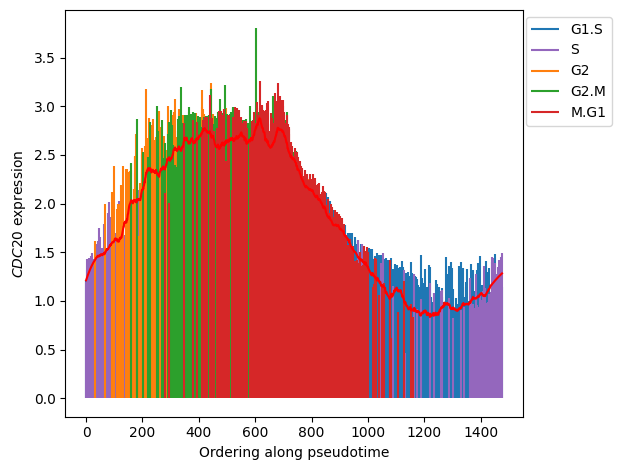

[3.1274449  3.16325738 3.1996115  ... 3.30330559 2.75359466 3.26269282]


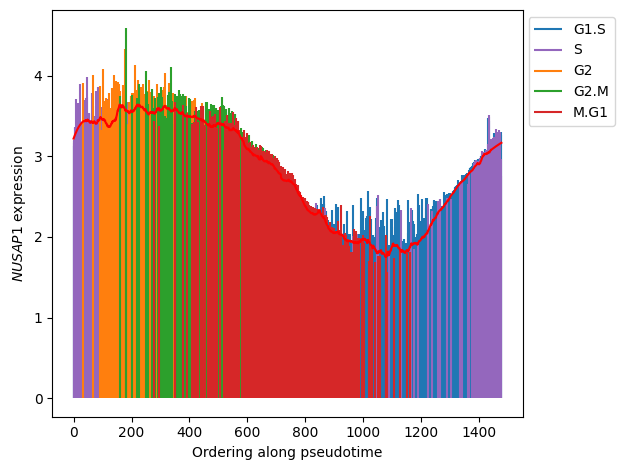

[1.74597167 1.75845043 1.77733225 ... 1.9327008  1.6493595  1.84353851]


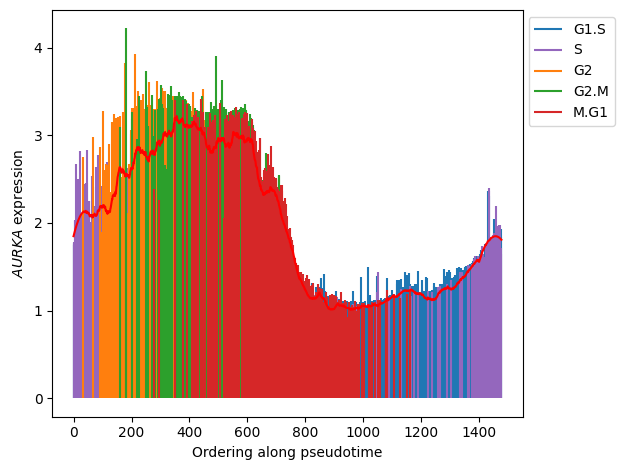

[1.88405808 1.87323494 1.86255205 ... 1.87047468 1.92598676 1.84875215]


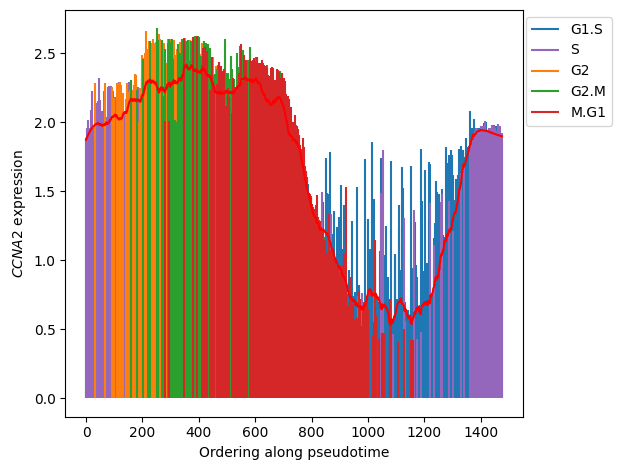

[1.38815625 1.3865725  1.39471283 ... 1.52451957 1.64598537 1.43709251]


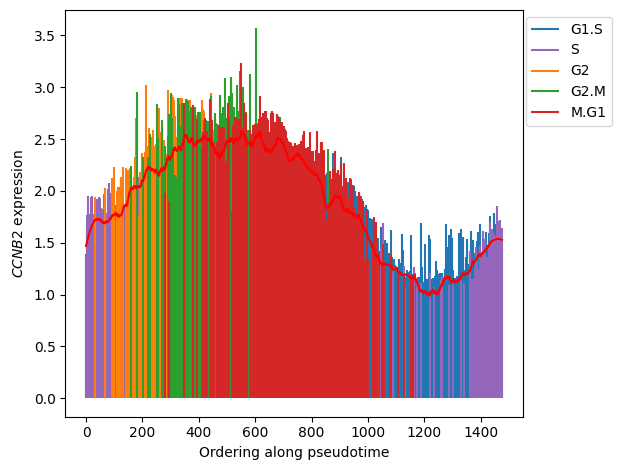

['CDC20']
[1.21804723 1.18907888 1.17308385 ... 1.16978806 1.48815894 1.13838535]


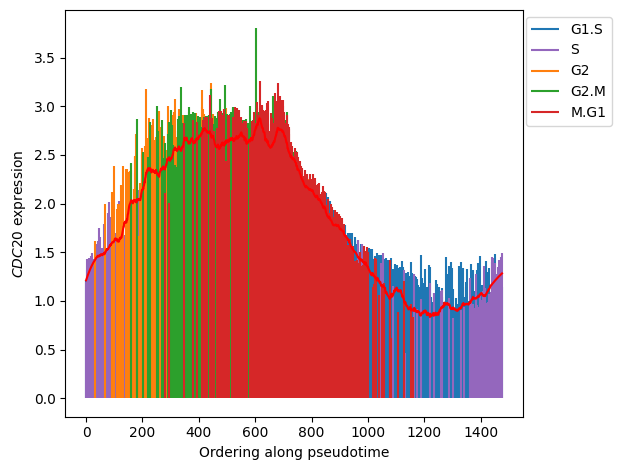

In [ ]:
desired_phases = subset_phase_genes.keys()
for desired_phase in desired_phases:
    phase_gene_list = phase_genes[desired_phase]
    print(phase_gene_list)
    make_dir(gene_save_path, desired_phase)
    phase_dir_path = os.path.join(gene_save_path, desired_phase)
    for gene in phase_gene_list:

        if gene in adata.var.index:

            phase_dir_path = os.path.join(gene_save_path,desired_phase)

            plot_gene_change(adata[adata.uns['mvae_pseudotime_order']],desired_phase,gene,colors,labels,phase_dir_path,ccPhase_palette=None,layer="enhanced")

Do the same thing for the gene expression matrix filtered for the cell cycle.

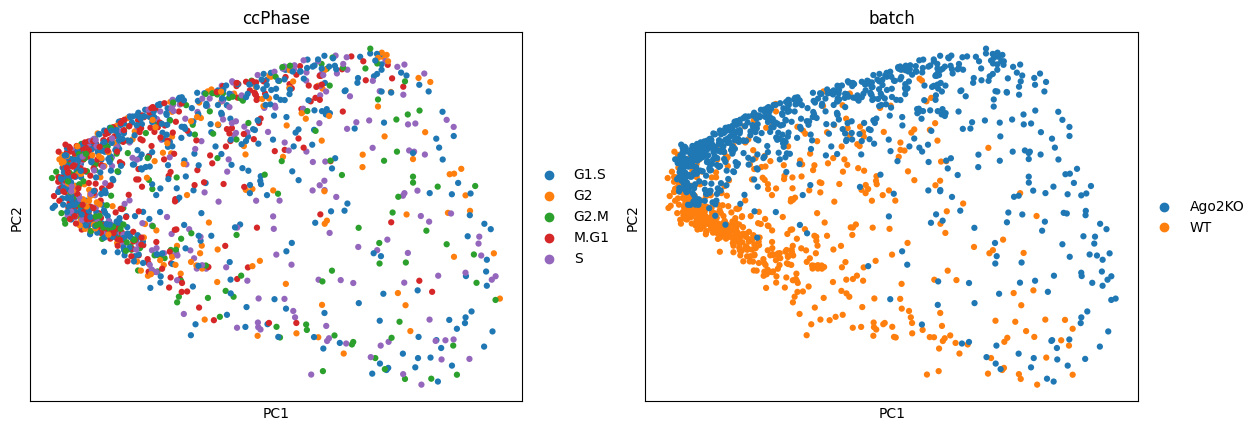

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4, layer="filtered")
sc.pp.log1p(adata, layer="filtered")
sc.pp.pca(adata, n_comps=50, layer="filtered")
sc.pl.pca(adata, color=["ccPhase", "batch"])

['CCNE2', 'ORC1', 'CCNE1', 'MCM6']
[1.98373715 1.82668253 2.53105211 ... 1.66351591 1.49195891 1.18090744]


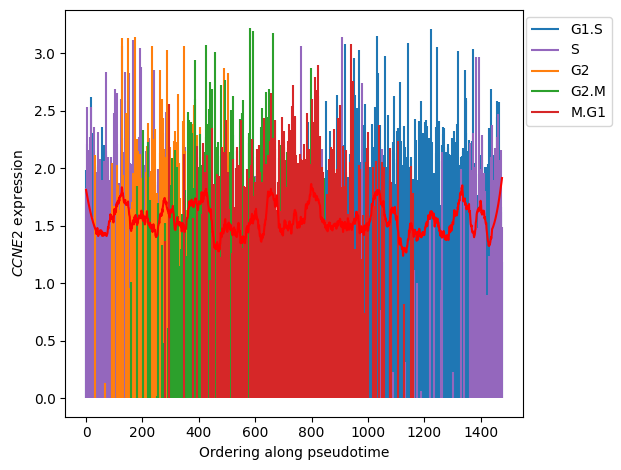

[1.21529204 1.1025581  0.79962254 ... 1.26462786 1.13226003 1.11903687]


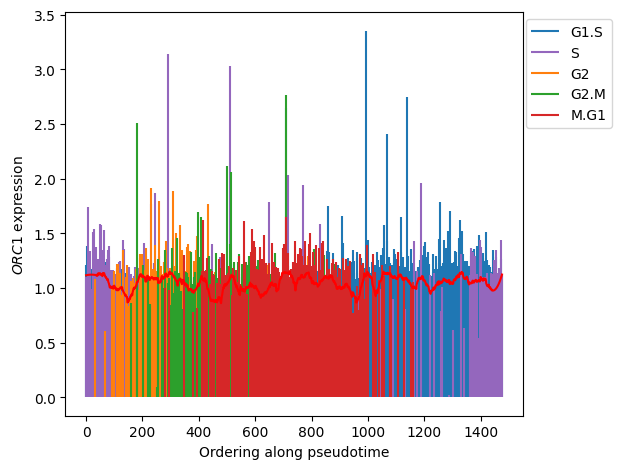

[0.62929232 0.80348888 0.40449348 ... 0.44990225 0.49346402 0.87989471]


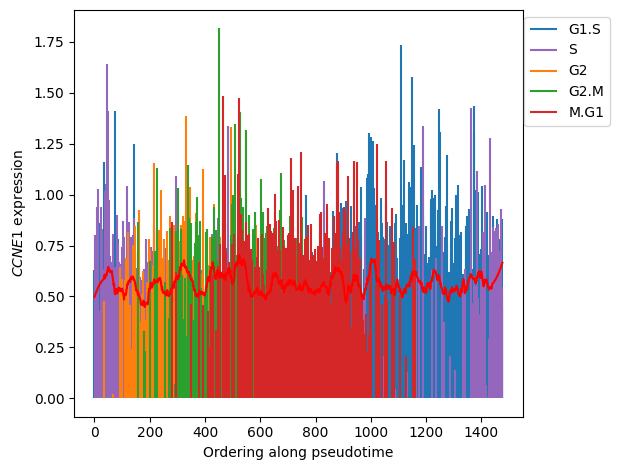

[1.84832664 1.51315226 1.33475801 ... 1.75651774 1.84429624 2.04460848]


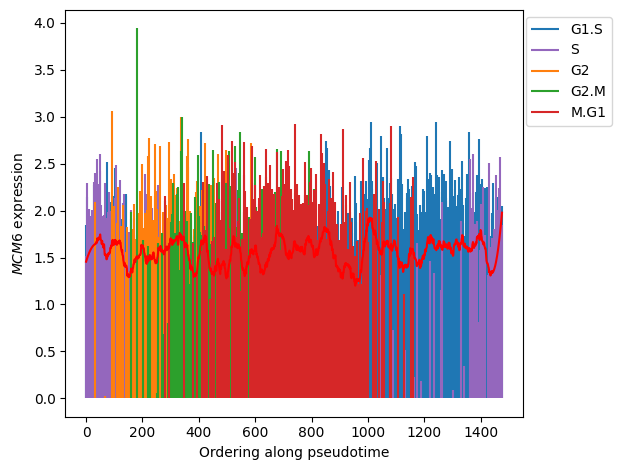

['CCNE2', 'RRM2']
[1.98373715 1.82668253 2.53105211 ... 1.66351591 1.49195891 1.18090744]


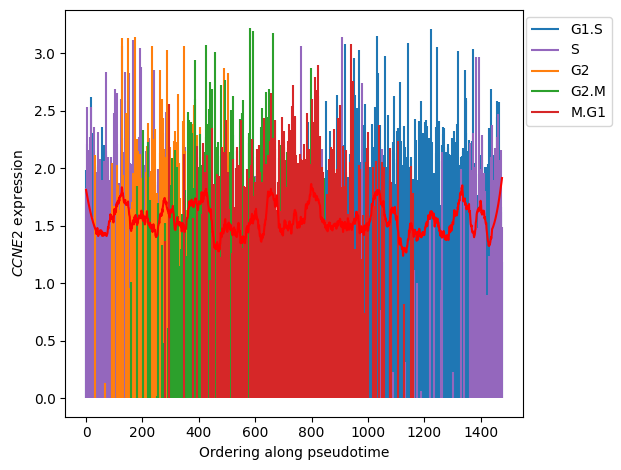

[2.55037082 2.41395965 3.05351244 ... 2.64221508 2.70341766 2.95120677]


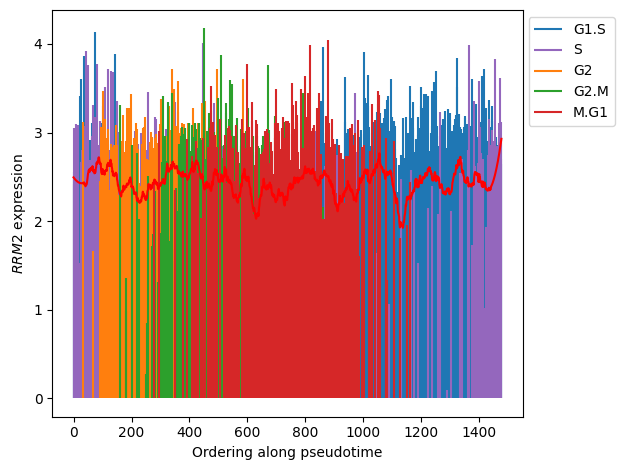

['CDK1', 'CCNF', 'NUSAP1', 'CCNA2']
[2.19767567 2.41144651 0.65751846 ... 1.98061802 1.53789984 1.84894326]


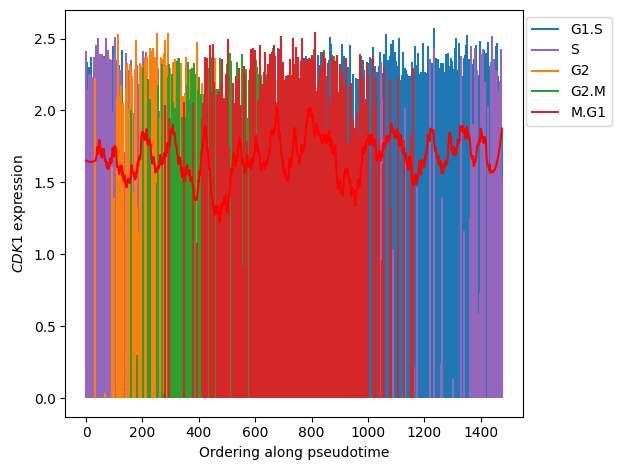

[0.53086193 0.43524701 0.30412084 ... 0.72959416 0.62759669 0.94500719]


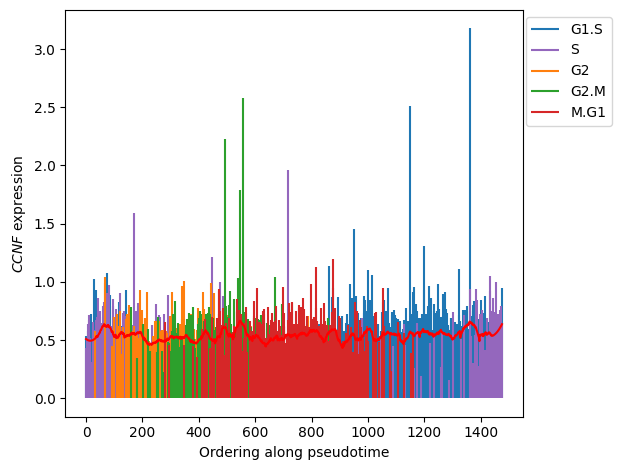

[2.36114781 2.52330037 2.74339175 ... 2.35550445 2.2280235  2.23855504]


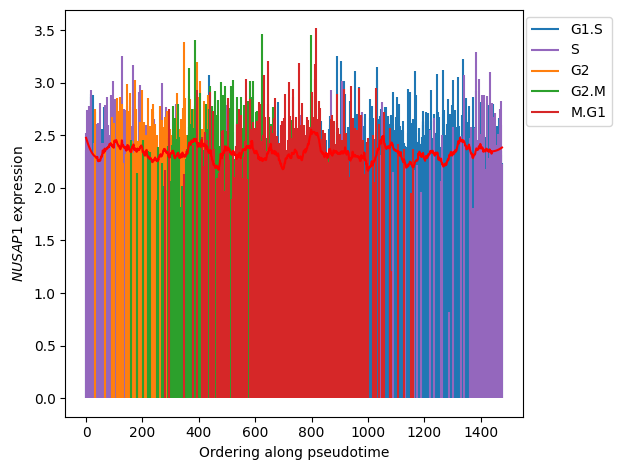

[1.832945   1.79248958 1.18835845 ... 2.01571635 1.83104078 1.79904749]


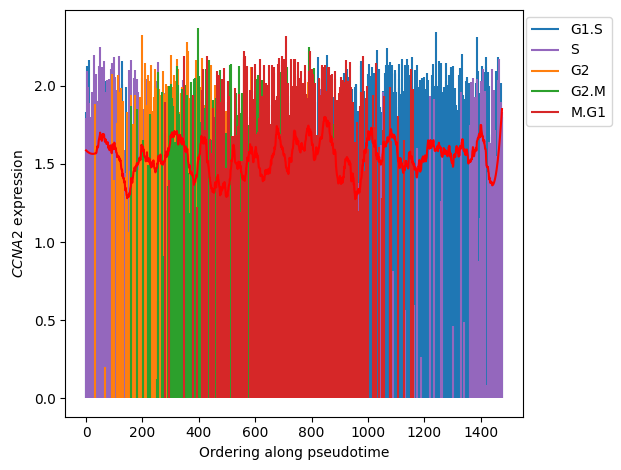

['CCNB1', 'CDC20', 'NUSAP1', 'AURKA', 'CCNA2', 'CCNB2']
[1.60478227 1.49787945 1.37933944 ... 1.60653134 1.57078803 1.87765034]


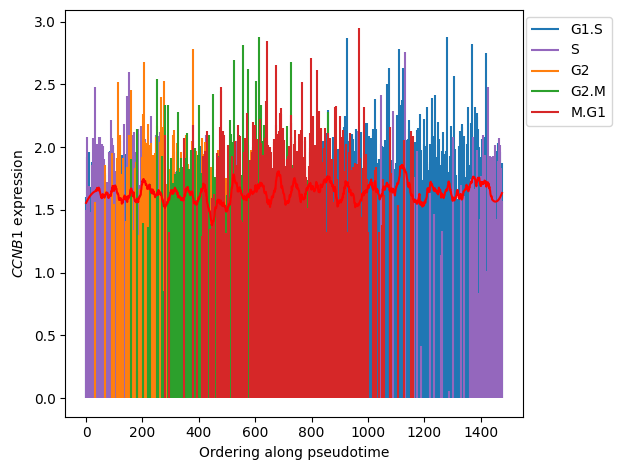

[1.30307998 1.42397324 0.52756617 ... 1.57544319 1.51656641 1.97787752]


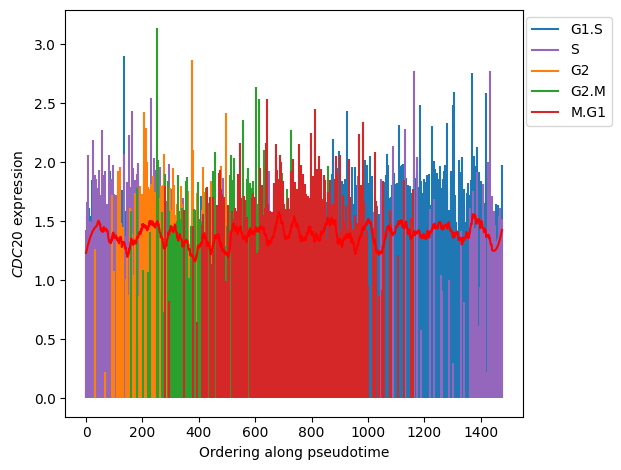

[2.36114781 2.52330037 2.74339175 ... 2.35550445 2.2280235  2.23855504]


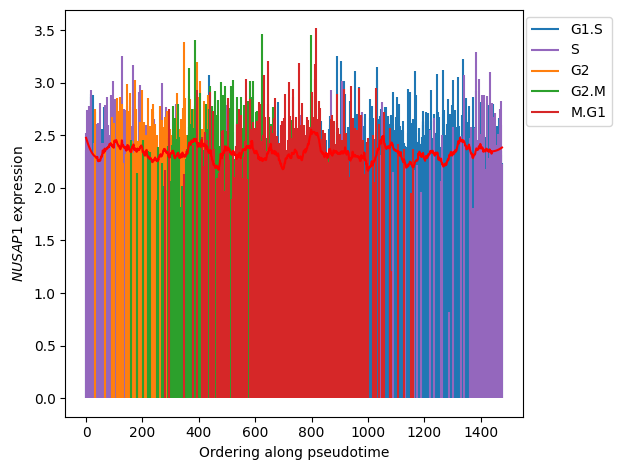

[1.05104445 0.84904133 2.2523321  ... 1.25200986 1.71304718 1.44389104]


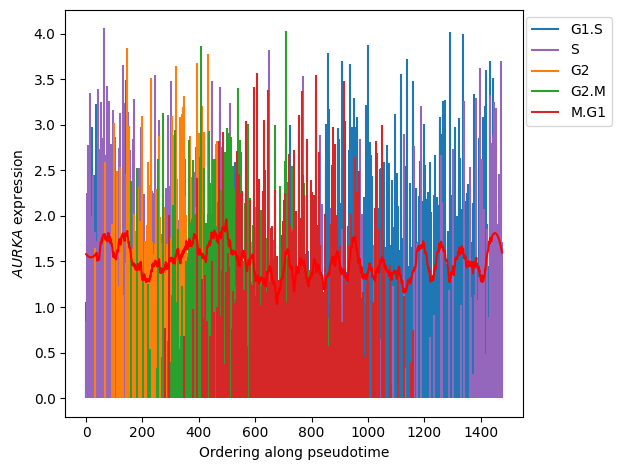

[1.832945   1.79248958 1.18835845 ... 2.01571635 1.83104078 1.79904749]


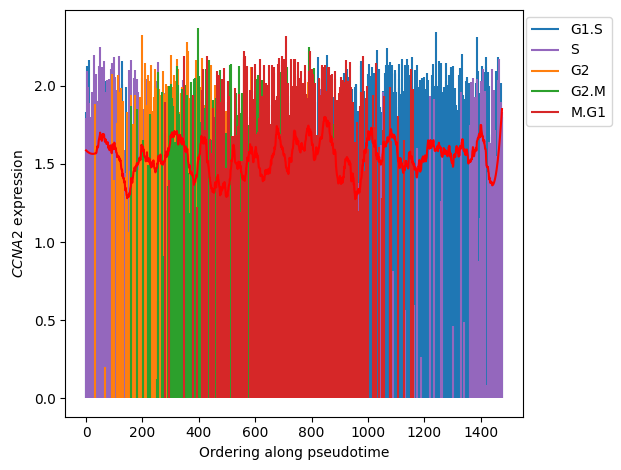

[1.42161173 1.14044525 2.027503   ... 2.07610633 2.69679759 2.3532229 ]


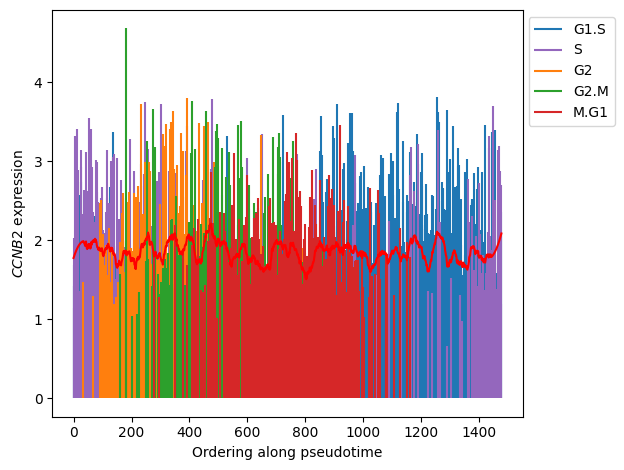

['CDC20']
[1.30307998 1.42397324 0.52756617 ... 1.57544319 1.51656641 1.97787752]


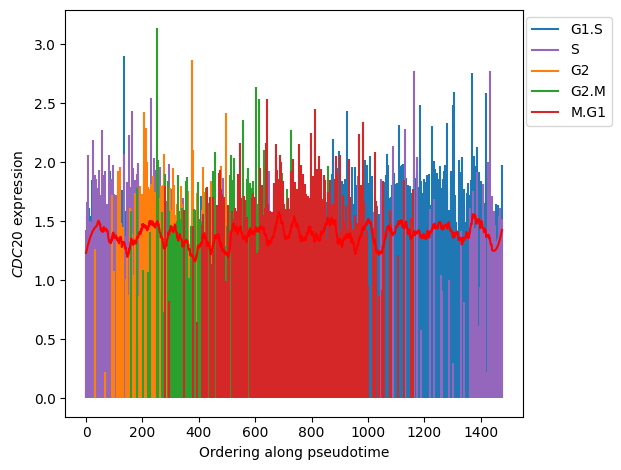

In [ ]:
desired_phases = subset_phase_genes.keys()
for desired_phase in desired_phases:
    phase_gene_list = phase_genes[desired_phase]
    print(phase_gene_list)
    make_dir(gene_save_path, desired_phase)
    phase_dir_path = os.path.join(gene_save_path, desired_phase)
    for gene in phase_gene_list:

        if gene in adata.var.index:

            phase_dir_path = os.path.join(gene_save_path,desired_phase)

            plot_gene_change(adata[adata.uns['mvae_pseudotime_order']],desired_phase,gene,colors,labels,phase_dir_path,ccPhase_palette=None,layer="filtered")